<a href="https://colab.research.google.com/github/1489685175z-coder/Bird_Speicy_Classification/blob/main/Bird_Speicy_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Project: Fine-Grained Bird Species Classification on CUB-200-2011
# Model: Pre-trained ResNet-18 fine-tuned
# Dataset: bentrevett/caltech-ucsd-birds-200-2011 from Hugging Face

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from datasets import load_dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image

In [2]:
# =============================================================================
# 1. Device & Hyperparameters
# =============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

BATCH_SIZE = 64             # Increase to 64~96 if GPU memory allows
NUM_EPOCHS = 15
LEARNING_RATE = 0.001
NUM_CLASSES = 200           # CUB-200 has 200 bird species

Using device: cuda


In [3]:
# =============================================================================
# 3. Load Dataset from Hugging Face
# =============================================================================
# Transforms
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
print("Loading dataset from Hugging Face...")
dataset = load_dataset("bentrevett/caltech-ucsd-birds-200-2011")

# Custom Dataset wrapper
class CUBDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image'].convert('RGB')
        label = item['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets
train_dataset = CUBDataset(dataset['train'], transform=train_transform)
test_dataset  = CUBDataset(dataset['test'], transform=test_transform)

# Split train into train + val
train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=torch.cuda.is_available())

val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=torch.cuda.is_available())

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=2, pin_memory=torch.cuda.is_available())

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}, Test samples: {len(test_dataset)}")
print("Data loading completed.")

Loading dataset from Hugging Face...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Train samples: 5094, Val samples: 900, Test samples: 5794
Data loading completed.


In [4]:
# =============================================================================
# 4. Model Definition
# =============================================================================
model = models.resnet18(pretrained=True)

# Replace the final fully connected layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)

model = model.to(device)

# Optional: Freeze early layers for faster & more stable fine-tuning
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer4 and fc (last residual block + classifier)
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# =============================================================================
# 5. Loss Function & Optimizer
# =============================================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [6]:
# =============================================================================
# 6. Training Function
# =============================================================================
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(loader), correct / total

In [7]:
# =============================================================================
# 7. Evaluation Function
# =============================================================================
def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc

In [8]:
# =============================================================================
# 8. Main Training Loop
# =============================================================================
best_val_acc = 0.0
print("Starting training...")

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc = evaluate(model, val_loader, device)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Acc: {val_acc:.4f}")

    # Learning rate scheduler & save best model
    scheduler.step(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet18_cub.pth")
        print(f"  → Best model saved (Val Acc: {val_acc:.4f})")

Starting training...


Evaluating: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


Epoch [1/15] | Train Loss: 4.1360 | Train Acc: 0.1362 | Val Acc: 0.2367
  → Best model saved (Val Acc: 0.2367)


Evaluating: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Epoch [2/15] | Train Loss: 2.6502 | Train Acc: 0.3594 | Val Acc: 0.3322
  → Best model saved (Val Acc: 0.3322)


Evaluating: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


Epoch [3/15] | Train Loss: 2.1738 | Train Acc: 0.4629 | Val Acc: 0.4156
  → Best model saved (Val Acc: 0.4156)


Evaluating: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


Epoch [4/15] | Train Loss: 1.8775 | Train Acc: 0.5210 | Val Acc: 0.4044


Evaluating: 100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Epoch [5/15] | Train Loss: 1.6687 | Train Acc: 0.5713 | Val Acc: 0.4744
  → Best model saved (Val Acc: 0.4744)


Evaluating: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


Epoch [6/15] | Train Loss: 1.5449 | Train Acc: 0.6035 | Val Acc: 0.4556


Evaluating: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


Epoch [7/15] | Train Loss: 1.4064 | Train Acc: 0.6341 | Val Acc: 0.4633


Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Epoch [8/15] | Train Loss: 1.3220 | Train Acc: 0.6506 | Val Acc: 0.4878
  → Best model saved (Val Acc: 0.4878)


Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.83it/s]


Epoch [9/15] | Train Loss: 1.2370 | Train Acc: 0.6741 | Val Acc: 0.4744


Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.76it/s]


Epoch [10/15] | Train Loss: 1.1467 | Train Acc: 0.7063 | Val Acc: 0.4889
  → Best model saved (Val Acc: 0.4889)


Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.80it/s]


Epoch [11/15] | Train Loss: 1.0832 | Train Acc: 0.7228 | Val Acc: 0.5144
  → Best model saved (Val Acc: 0.5144)


Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.87it/s]


Epoch [12/15] | Train Loss: 1.0141 | Train Acc: 0.7348 | Val Acc: 0.5089


Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.84it/s]


Epoch [13/15] | Train Loss: 0.9794 | Train Acc: 0.7452 | Val Acc: 0.5056


Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.90it/s]


Epoch [14/15] | Train Loss: 0.9517 | Train Acc: 0.7570 | Val Acc: 0.5322
  → Best model saved (Val Acc: 0.5322)


Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.82it/s]

Epoch [15/15] | Train Loss: 0.8977 | Train Acc: 0.7656 | Val Acc: 0.5044


In [9]:
# =============================================================================
# 9. Final Test Evaluation
# =============================================================================
print("\nLoading best model for final test...")
model.load_state_dict(torch.load("best_resnet18_cub.pth", map_location=device))
test_acc = evaluate(model, test_loader, device)
print(f"Final Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")


Loading best model for final test...


Evaluating: 100%|██████████| 91/91 [00:30<00:00,  3.00it/s]

Final Test Accuracy: 0.6177 (61.77%)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Best model loaded for error analysis.


Collected 5794 test predictions.


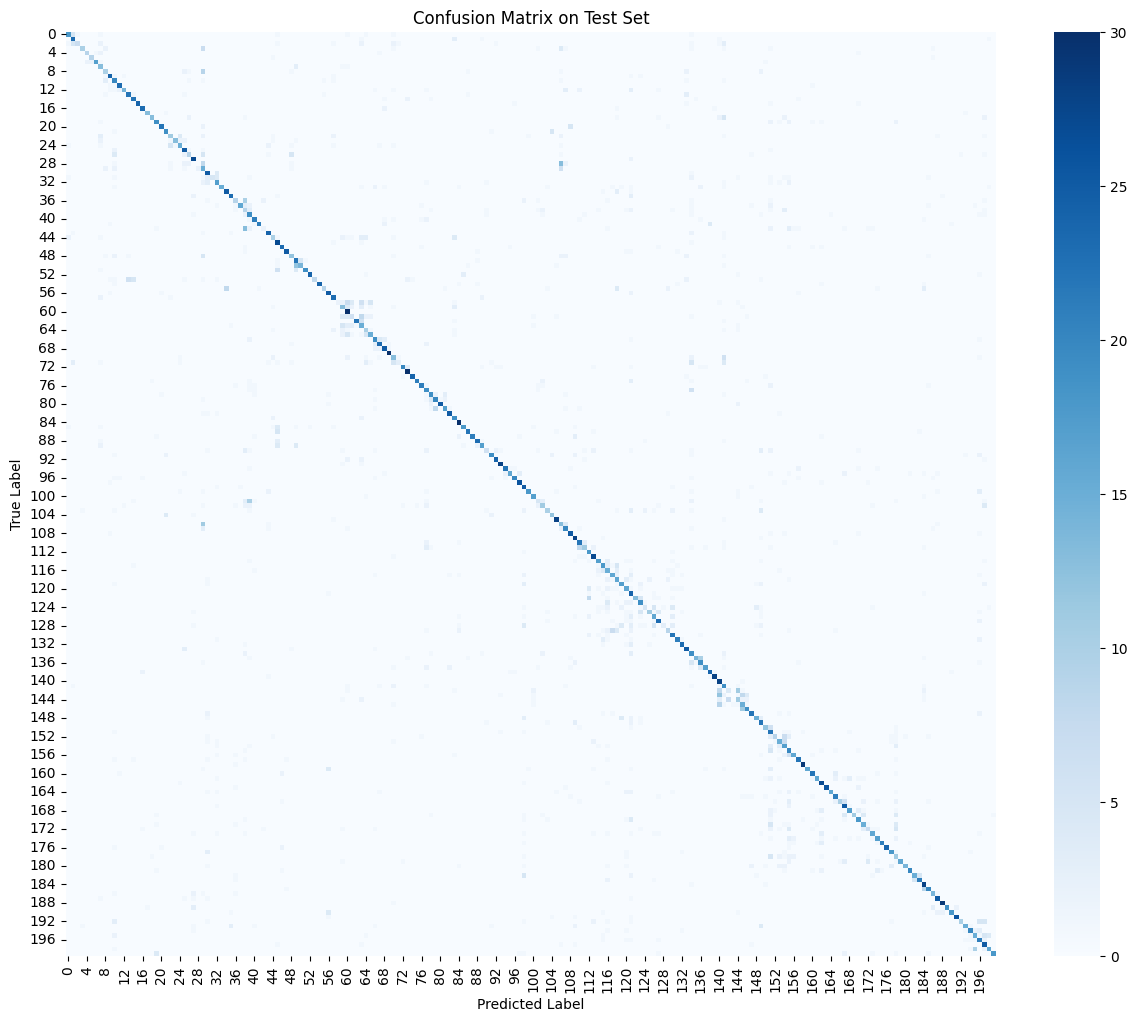

Top 5 most confused pairs (true → predicted, count):
  28 → 106 : 13 times
  42 → 38 : 13 times
  50 → 49 : 12 times
  143 → 140 : 12 times
  106 → 29 : 11 times
Re-computed Test Accuracy: 0.6177 (61.77%)


In [10]:
# =============================================
# Error Analysis & Confusion Matrix
# =============================================

import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Re-load the best model
model = models.resnet18(pretrained=False)  # No pretrained here, we load our weights
model.fc = nn.Linear(model.fc.in_features, 200)  # 200 classes
model = model.to(device)

# Load the saved best checkpoint
model.load_state_dict(torch.load("best_resnet18_cub.pth", map_location=device))
model.eval()

print("Best model loaded for error analysis.")

# Collect all predictions and true labels from test set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Collecting predictions for error analysis"):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

print(f"Collected {len(all_preds)} test predictions.")

# 1. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')  # Save for report
plt.show()

# 2. Top 5 most confused pairs
errors = [(true, pred) for true, pred in zip(all_labels, all_preds) if true != pred]
if errors:
    most_common_errors = Counter(errors).most_common(5)
    print("Top 5 most confused pairs (true → predicted, count):")
    for (true_label, pred_label), count in most_common_errors:
        print(f"  {true_label} → {pred_label} : {count} times")
else:
    print("No errors found (perfect prediction!).")

# Optional: Print overall test accuracy again
test_acc = accuracy_score(all_labels, all_preds)
print(f"Re-computed Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

In [11]:
import torch

def topk_accuracy(outputs, targets, topk=(1,5)):
    """
    Compute top-k accuracy.
    outputs: [batch, num_classes]
    targets: [batch]
    """
    maxk = max(topk)
    _, pred = outputs.topk(maxk, dim=1, largest=True, sorted=True)  # [batch, maxk]
    pred = pred.t()  # [maxk, batch]
    correct = pred.eq(targets.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append((correct_k / targets.size(0)).item())
    return res

model.eval()
top1_total, top5_total, n_total = 0.0, 0.0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        t1, t5 = topk_accuracy(outputs, labels, topk=(1,5))
        bs = labels.size(0)
        top1_total += t1 * bs
        top5_total += t5 * bs
        n_total += bs

print(f"Test Top-1 Accuracy: {top1_total/n_total:.4f}")
print(f"Test Top-5 Accuracy: {top5_total/n_total:.4f}")

Test Top-1 Accuracy: 0.6177
Test Top-5 Accuracy: 0.8725


In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix shape:", cm.shape)

Confusion matrix shape: (200, 200)


Number of misclassified samples: 2215


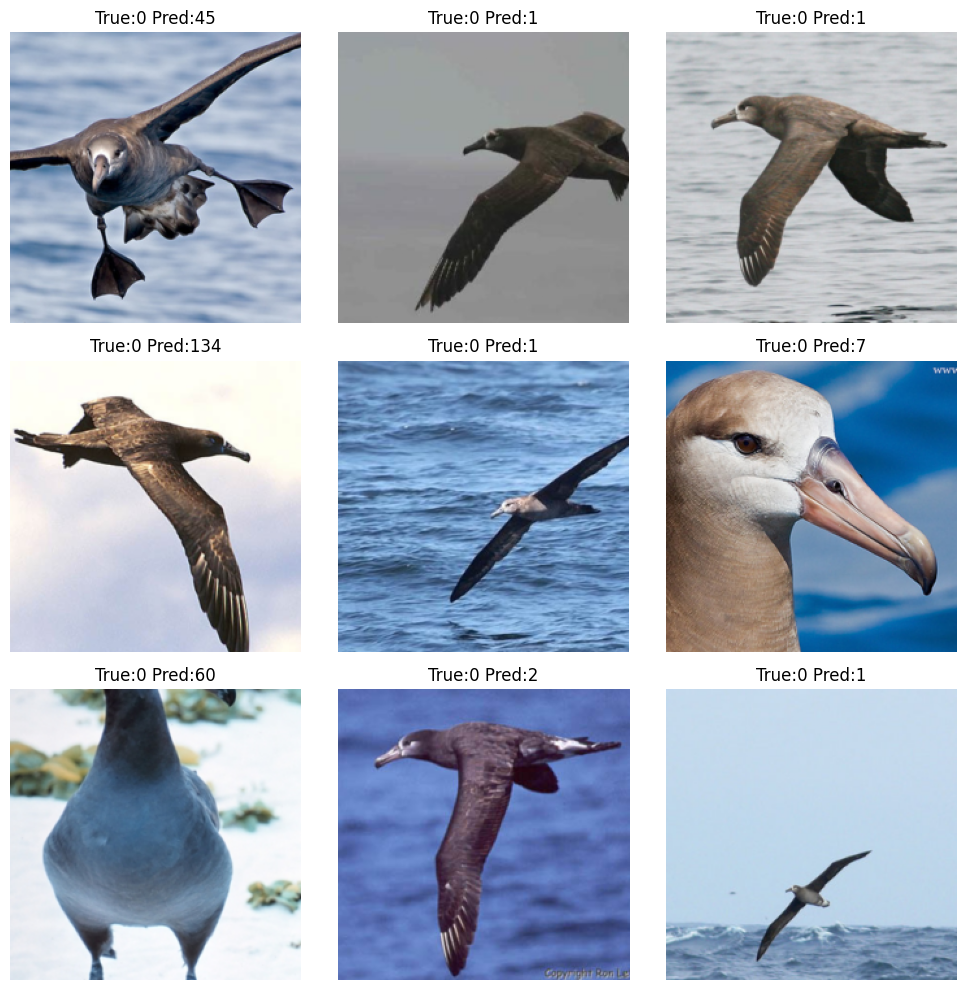

In [13]:
import matplotlib.pyplot as plt

# Find indices of misclassified samples
wrong_idx = np.where(all_preds != all_labels)[0]
print("Number of misclassified samples:", len(wrong_idx))

# Display the first 9 misclassified images
show_n = 9
fig, axes = plt.subplots(3, 3, figsize=(10,10))
axes = axes.flatten()

# Collect images from test_loader
images_list = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images_list.append(images)
        labels_list.append(labels)
images_all = torch.cat(images_list, dim=0)
labels_all = torch.cat(labels_list, dim=0)

for i in range(show_n):
    idx = wrong_idx[i]
    img = images_all[idx]

    # # Denormalize (using ImageNet mean/std)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img * std + mean
    img = img.permute(1,2,0).numpy()
    img = np.clip(img, 0, 1)

    axes[i].imshow(img)
    axes[i].set_title(f"True:{labels_all[idx].item()} Pred:{all_preds[idx]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()